<b>Coding Assignment 2<br>
CS 401: Quantum Computing <br>
Dr. Kell, Spring 2023 </b>

<b> Instructions </b> 

To complete the assignment, please fill in all coding cells as instructed below, and then submit the file on Notebowl once completed. Before you turn in your submission, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel → Restart) and then run all cells (in the menubar, select Cell → Run All). Make sure you fill in any place that says YOUR CODE GOES HERE.
    
<b> Constraints on references and collaborations</b>
    
 <item> <i> You may:</i> Reference any chapter from the course textbook, references, and relevant Wikipedia pages. You are permitted to collaborate with others in the class in groups of 2-3, but these collaborations should be solely conceptual (i.e., clarifying the problem, brainstorming algorithms, etc.).
     
 <item> <i> You may not</i>: 
     
* You may not share code or work with others when writing your code.
<br> 
     
* Reference the Qiskit Quantum Teleportion guide (This is Chapter 3.11 in the Qiskit online textbook.)
    
<b> Finally: Be sure to use proper coding style for all your solutions!</b> For example, you should write docstrings for all functions, include useful in-line comments explaining how your code works, write clean code with readable variable names, etc.. You will lose points if you write sloppy code with poor style (e.g., not writing docstrings for any of your functions). 
    
Best of luck!


In [91]:
# Specify your name below
NAME = "Khoi Le"

In [92]:
# Qiskit and NumPy imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
from qiskit.visualization import state_visualization
from qiskit.visualization import plot_state_city, plot_bloch_multivector
import qis401, random, math, cmath 

## Part 1 [20 points] 
In this first part, you will implement the Quantum Teleportation algorithm using Qiskit.  You must structure your solution by implementing the following API:

* <code>random_qubit()</code>: returns a two-element list containing the amplitudes of a randomly selected qubit (i.e., the first value is the amplitude for $|0\rangle$ and the second value is the amplitude for $|1\rangle$). To produce the random qubit, you must generate the parameters $\theta$ and $\varphi$ in the Bloch sphere equation (Equation 1.4 on page 15 in NC) uniformly at random and then use these parameters to calculate each amplitude.
<br>

* <code>initialize_circuit(teleport_amps)</code>: Takes in a two-element list <code>teleport_amps</code> and returns the six tuple <code>(circ, teleport, alice, bob, t_measure, a_measure)</code>, where <code>teleport, alice,</code>, and <code>bob</code> are the <code>QuantumRegister</code> objects that will be used in the algorithm; <code>t_result</code> and <code>a_result</code> are the <code>ClassicalRegister</code> objects that will be use to store Alice's measurement of the <code>teleport</code> and <code>alice</code> registers; and <code>circ</code> is the overall <code>QuantumCircuit</code> object itself. Furthermore, the state of <code>teleport</code> should be initialized to be the values in <code>teleport_amps</code> (which will be created by previously calling <code>random_qubit()</code>). Use the <code>QuantumCircuit</code> method <code>initialize()</code> to perform this initialization of the teleportation qubit. Also at the end of the function, call the <code>barrier()</code> method to block off this initial phase of the algorithm.  
<br>

* <code>make_epr(circ, alice, bob)</code>: takes in the QT circuit and quantum registers for Alice and Bob and puts them in an EPR pair. At the end of the function, again use the <code>barrier()</code> method to block off this segment of the algorithm. 
<br>

* <code>alice_computation(circ, teleport, alice,  t_measure, a_measure)</code>: Takes in the QT circuit along with the registers needed to perform Alice's part of the algorithm. Use the <code>barrier()</code> method twice to create two blocks, one for her quantum operations and one for her measurements. 
<br>

* <code>bob_computation(circ, bob, t_measure, a_measure)</code>:  Takes in the QT circuit along with the registers needed to perform Bob's part of the algorithm

Implement the above functions in a single cell. To generate your output, create three additional cells that do the following:


* Your first cell should simply create <code>teleport_amps</code> by calling <code>random_qubit()</code>. You should then pass <code>teleport_amps</code> into the Qiskit function <code>plot_bloch_multivector()</code> to visualize the qubit as a Bloch sphere.  The output of the cell should look something like:

<div align="center">
<img src="input-qubit.png" width="200">
</div>

* Your second cell should then construct the circuit by calling the functions from the API, and then use the <code>draw()</code> method to display the circuit. The output of the cell should look similar to the final circuit in the Quantum Teleportation slides from class (along with the initialization block at the beginning that generates the random qubit). 
<br>

* Your third cell should then simulate the circuit by calling <code>qis401.simulate_circuit()</code>. You should then use the returned <code>result</code> object to get the final state vector, and then pass this into <code>plot_bloch_multivector()</code> to visualize the final state of <code>teleport</code>, <code>alice</code>, and <code>bob</code>. The output should look something like:

<div align="center">
<img src="output-qubit.png" width="600">
</div>

In particular, the first and second spheres (corresponding to the teleport and Alice qubits) should be pointing either straight up or down (since they've been measured). The third sphere corresponding to Bob's qubit should be pointing in the same direction as the original sphere for the teleportation qubit. 
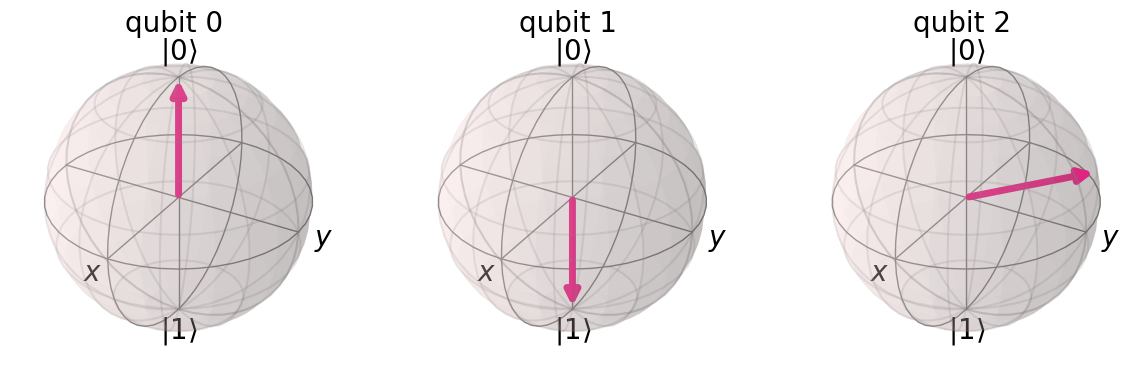

In [93]:
def random_qubit():
    """
    This function randomly initiates a random qubit using Bloch sphere representation.
    We randomly select theta between 0 and pi and phi between 0 and 2*pi.

    Return: a list of two elements corresponding to the parameters of the 0-ket and 1-ket.
    """
    theta = random.random() * math.pi
    phi = random.random() * math.pi * 2
    return [math.cos(theta/2), math.sin(theta/2)*(math.cos(phi)+math.sin(phi)*1j)]

def initialize_circuit(teleport_amps):
    """
    Initiate the parameters of the circuit. Initiate the quantum register teleport
    as the state of teleport_amps

    Return:
        the circuit and the five quantum registers and classic registers of the circuit.
    """
    teleport = QuantumRegister(1, "teleport")
    alice = QuantumRegister(1, "alice")
    bob = QuantumRegister(1, "bob")
    t_measure = ClassicalRegister(1, "t_measure")
    a_measure = ClassicalRegister(1, "a_measure")
    circ = QuantumCircuit(teleport, alice, bob, t_measure, a_measure)
    circ.initialize(teleport_amps, 0)
    return (circ, teleport, alice, bob, t_measure, a_measure)

def make_epr(circ, alice, bob):
    """
    This function transforms the state of a and b into an EPR pair.
    """
    circ.h(alice)
    circ.cx(alice, bob)
    # Create a barrier at the end.
    circ.barrier()

def alice_computation(circ, teleport, alice,  t_measure, a_measure):
    """
    This function execute the Alice computation and Alice measurement on the
    qubit 'teleport' and 'alice' 
    """

    # Perform Alice computation
    circ.cx(teleport, alice)
    circ.h(teleport)
    circ.barrier()

    # Perform Alice measurement
    circ.measure(teleport, t_measure)
    circ.measure(alice, a_measure)
    circ.barrier()

def bob_computation(circ, bob, t_measure, a_measure):
    """
    This function execute the Bob computation.
    """
    circ.x(bob).c_if(a_measure, 1)
    circ.z(bob).c_if(t_measure, 1)
    circ.barrier()


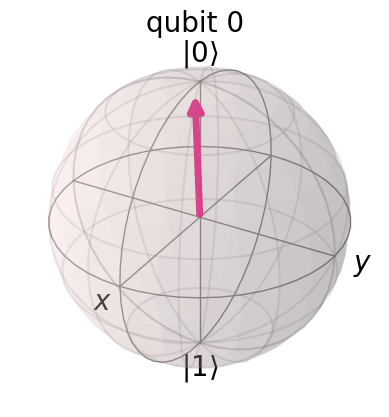

In [94]:
# Generate a random qubit
teleport_amps = random_qubit()
plot_bloch_multivector(teleport_amps)

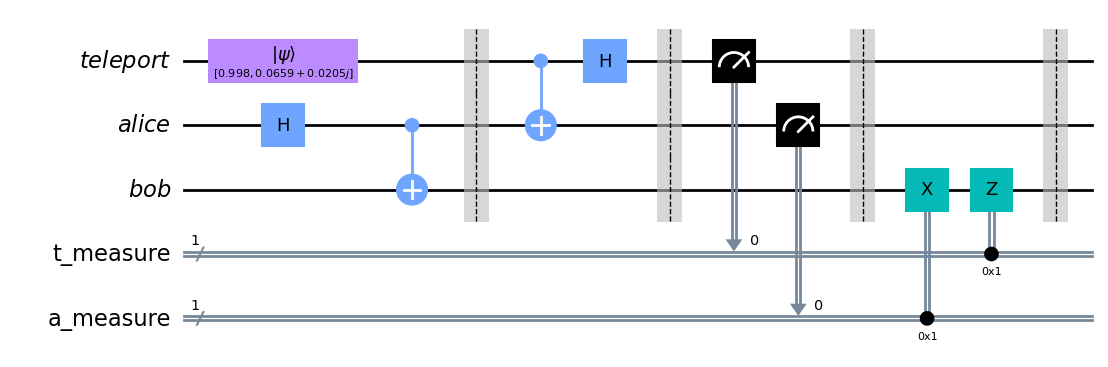

In [95]:
# Create the teleportation circuit using the above functions
circ, teleport, alice, bob, t_measure, a_measure = initialize_circuit(teleport_amps)
make_epr(circ, alice, bob)
alice_computation(circ, teleport, alice,  t_measure, a_measure)
bob_computation(circ, bob, t_measure, a_measure)

circ.draw("mpl")

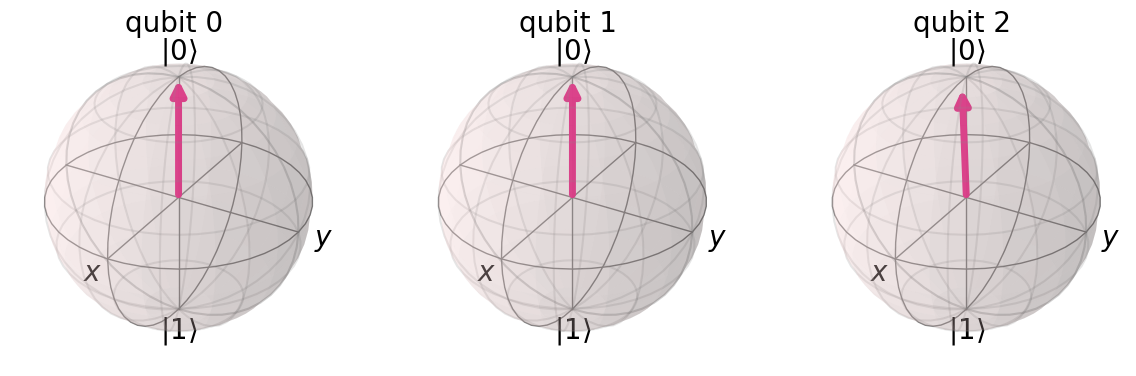

In [96]:
# Simulate the circuit and draw the states of teleport, alice, and bob
result = qis401.simulate_circuit(circ)
output_state = result.get_statevector()
plot_bloch_multivector(output_state)

## Part 2 [30 points] 

In this part, you will now implement the Quantum Teleportation algorithm using NumPy vectors and matrices. You will implement the same API as in Part 1. The differences between the functions parameters and return values are specified as follows: 

* <code>random_qubit()</code>: Reuse the implementation from Part 1.
<br>

* <code>initialize_circuit(teleport_amps)</code>: Again takes in a two element list <code>teleport_amps</code>, but now returns an 8-dimensional NumPy vector that has initialized the amplitudes of the teleportation qubit according to <code>teleport_amps</code>. Note that in order to store complex values in the NumPy array state vector, you need to initialize the state vector using <code>zeros(8, dtype=numpy.complex_)</code>.
<br>

* <code>make_epr(state)</code>: Takes in the current state vector and returns the resulting vector after applying the unitary matrices that put Alice and Bob's qubits in an EPR pair. (Like we saw in class, you should use the <code>numpy.kron()</code> function to create the unitary matrices corresponding to each gate). 
<br>

* <code>alice_computation(state)</code>: Takes the current state vector and returns a two-tuple <code>(output_state, measure)</code>, where <code>output_state</code> is the resulting state after first applying the unitary matrices corresponding to Alice's quantum computations and then measuring the teleport and Alice qubits; <code>measure</code> should then be one of four strings <code>"00"</code>, <code>"01"</code>, <code>"10"</code>, or <code>"11"</code> that indicates Alice's measurement result. Note you will have to manually simulate the process of measurement, i.e., you will need to randomly select the measurement outcome and then renormalize the quantum state according to the outcome. 
<br>

* <code>bob_computation(state, measure)</code>:  Takes the current state vector and Alice's measurement result, and returns the resulting state vector after applying the unitary matrices corresponding to Bob's computations.

Again, implement the functions in the above API in a single cell. (Note to avoid having to repeatedly construct the single qubit matrices for the H, Z, X, and CX gates in each function, it's fine to declare these matrices as global variables at the top). 

To generate your output, again write a single cell that creates the random teleportation qubit and displays its state as a Bloch sphere. Then, create a second cell that uses the functions in your API to apply the QT algorithm to the intial state vector. At the end of the cell, you should display the state of Bob's qubit as a single Bloch sphere, which should match the original Bloch sphere of the teleportation qubit. 


In [97]:
# Declare the common gates: h, x, i, z.
h = np.array([[1/cmath.sqrt(2), 1/cmath.sqrt(2)], [1/cmath.sqrt(2), -1/cmath.sqrt(2)]])
x =  np.array([[0, 1], [1, 0]])
i =  np.array([[1, 0], [0, 1]])
z = np.array([[1, 0], [0, -1]])

# Declare the controlled not gate: cx1 is the gate where the first bit is the control bit,
# cx2 is the gate where the second bit is the control bit.
cx1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
cx2 = np.array([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]])

In [98]:
def renormalize(state):
    """
    This function re-normalize the state of qubits
    """
    prob = 0
    length = state.shape[0]

    # This loop calculate the sum of squared amplitude of every qubit
    for j in range(length):
        if state[j]:
            prob += abs(state[j])**2
    prob = math.sqrt(prob)

    # Re-normalize the state
    for j in range(length):
        if state[j]:
            state[j] /= prob
    return state

def random_measurement():
    """
    This function randomly select the 
    """
    ans = ["00", "01", "10", "11"]
    return ans[int(random.random()/0.25)]

def initialize_circuit(teleport_amps):
    """
    Initiate the state based on the state teleport_amps.
    The state will be an numpy array of 8 elements.
    """
    ans = np.zeros(8, dtype=np.complex_)
    ans[0] = teleport_amps[0]
    ans[4] = teleport_amps[1]
    return ans

def make_epr(state):
    """
    This function transforms the state of a and b into an EPR pair.
    """
    h_gate = np.kron(i, h)
    h_gate = np.kron(h_gate, i)
    cx_gate = np.kron(i, cx1)
    ans = cx_gate @ h_gate @ state
    return ans

def alice_computation(state):
    """
    This function execute the Alice computation and Alice measurement on the
    qubit 'teleport' and 'alice' 
    """
    cx_gate = np.kron(cx1, i)
    h_gate = np.kron(h, i)
    h_gate = np.kron(h_gate, i)
    ans = h_gate @ cx_gate @ state
    measure = random_measurement()

    # Measure the state based on the random measurement
    if int(measure[0]):
        for j in range(4):
            ans[j] = 0
    else:
        for j in range(4,8):
            ans[j] = 0
    if not int(measure[1]):
        for j in range(2, 8, 4):
            ans[j] = 0
            ans[j+1] = 0
    else:
        for j in range(0, 8, 4):
            ans[j] = 0
            ans[j+1] = 0
    
    # Re-normalize the state
    ans = renormalize(ans)

    return (ans, measure)

def bob_computation(state, measure):
    """
    This function execute the Bob computation.
    """
    x_gate = np.kron(i, i)
    x_gate = np.kron(x_gate, x)
    z_gate = np.kron(i, i)
    z_gate = np.kron(z_gate, z)
    if int(measure[1]):
        state = x_gate @ state
    if int(measure[0]):
        state = z_gate @ state
    return state

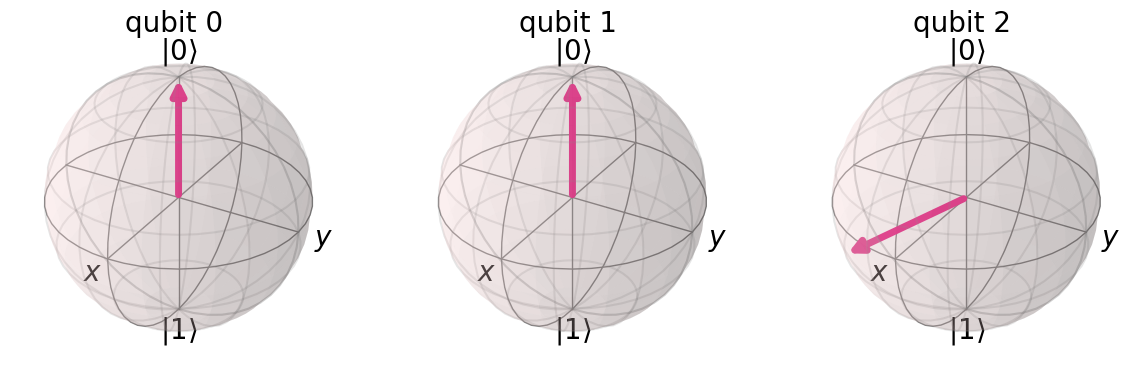

In [99]:
# Initiate the state and plot it in Bloch sphere
teleport_amps = random_qubit()
state = initialize_circuit(teleport_amps)
output_sv = Statevector(state)
plot_bloch_multivector(output_sv)

10


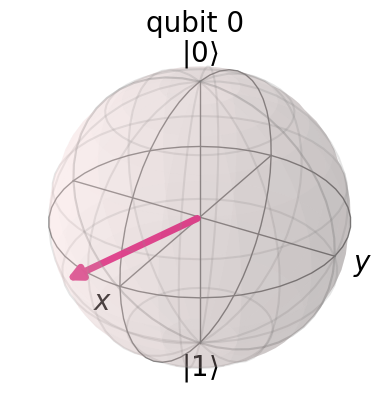

In [100]:
# Similate the circuit and plot the result in the Bloch sphere
state = make_epr(state)
state, measure = alice_computation(state)
state = bob_computation(state, measure)
print(measure)
index = {"00": 0, "01": 2, "10": 4, "11": 6}
output_sv = Statevector(state[index[measure]:index[measure]+2])
plot_bloch_multivector(output_sv)